In [ ]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import numpy as np

#input: a list of images
def plotFigures(images):
    imageAmount = len(images)
    plt.figure(1)
    n_columns = 6
    n_rows = np.ceil(imageAmount/n_columns)+1
    sideLength = np.sqrt(len(images[0]))
    
    for i in range(imageAmount):
        plt.subplot(n_rows,n_columns,i+1)
        plt.imshow(np.reshape(images[i],[sideLength.astype(int),sideLength.astype(int)]),cmap="gray")
#end


mnist = input_data.read_data_sets('./data')
trainDatas = mnist.train.next_batch(1000)
imageDatas = trainDatas[0]
labelDatas = trainDatas[1]
# print(imageDatas[0].shape)
# images = []
# for i in range(10):
#     images.append(imageDatas[i])
# plotFigures(images)
# plt.show()

#define a function to transform image dataset to batch set



In [ ]:
def fit_pca_shape(datasets,depth):
    factor=np.power(2,depth)
    length=32/factor
    print ('fit_pca_shape: length: {}'.format(length))
    idx1=range(0,int(length),2)
    idx2=[i+2 for i in idx1]
    print ('fit_pca_shape: idx1: {}'.format(idx1))
    data_lattice=[datasets[:,:,i:j,k:l] for ((i,j),(k,l)) in product(zip(idx1,idx2),zip(idx1,idx2))]
    data_lattice=np.array(data_lattice)
    print ('fit_pca_shape: data_lattice.shape: {}'.format(data_lattice.shape))

    #shape reshape
    data=np.reshape(data_lattice,(data_lattice.shape[0]*data_lattice.shape[1],data_lattice.shape[2],2,2))
    print ('fit_pca_shape: reshape: {}'.format(data.shape))
    return data


def PCA_and_augment(data_in,number_important):
    # data reshape
    data=np.reshape(data_in,(data_in.shape[0],-1))
    print( 'PCA_and_augment: {}'.format(data.shape))
    # mean removal
    mean = np.mean(data, axis=0)
    datas_mean_remov = data - mean
    print( 'PCA_and_augment meanremove shape: {}'.format(datas_mean_remov.shape))

    # PCA, retain all components
    pca=PCA(n_components = number_important)
    pca.fit(datas_mean_remov)
    comps=pca.components_

    # augment, DC component doesn't
    comps_aug=[vec*(-1) for vec in comps]
    comps_complete=np.vstack((comps,comps_aug))
    shapeComps = comps.shape
    mean_kernel = np.ones(shapeComps[1])
    mean_kernel = mean_kernel / np.sqrt(shapeComps[1])
    comps_complete = np.vstack((comps_complete,mean_kernel))
    print( 'PCA_and_augment comps_complete shape: {}'.format(comps_complete.shape))
    return comps,comps_complete

# def one_stage_saak_trans(datasets=None,depth=0,number_important=3):

#     print ('one_stage_saak_trans: datasets.shape {}'.format(datasets.shape))
#     input_channels=datasets.shape[1]

#     # change data shape, (14*60000,4)
#     data_flatten=fit_pca_shape(datasets,depth)

#     # augmented components
#     comps,comps_complete=PCA_and_augment(data_flatten,number_important)
#     print ('one_stage_saak_trans: comps_complete: {}'.format(comps_complete.shape))
#     # print('one_saak_trans, non-aug kernel size:{}'.format(comps.shape))

#     # get filter and datas, (7,1,2,2) (60000,1,32,32)
#     filters=ret_filt_patches(comps_complete,input_channels)
#     print ('one_stage_saak_trans: filters: {}'.format(filters.shape))

#     # output (60000,7,14,14)
#     relu_output,filt=conv_and_relu(filters,datasets,stride=2)

#     data=relu_output.data.numpy()
#     print ('one_stage_saak_trans: output: {}'.format(data.shape))
#     return data,filt,relu_output


In [ ]:
#this block is to test the tf.nn.conv2d
print(imageDatas.shape)
imageData = imageDatas[8]
sideLength = np.sqrt(len(imageData))
plt.imshow(np.reshape(imageData,[sideLength.astype(int),sideLength.astype(int)]),cmap="gray")
plt.show()

# get the components
pcaDataSet = fit_pca_shape(imageDatas,0)
w,w_aug = PCA_and_anugment(pcaDataSet,0)

# tf.nn.conv2d(imageData,W, strides = [1,2,2,1],padding = 'SAME')

In [50]:
import torch
import argparse
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from data.datasets import MNIST
import torch.utils.data as data_utils
from sklearn.decomposition import PCA
import torch.nn.functional as F
from torch.autograd import Variable
from itertools import product
from sklearn import svm

# argument parsing
print(torch.__version__)
batch_size = 1
test_batch_size = 1
kwargs = {}
train_loader = data_utils.DataLoader(MNIST(root='./data', train=True, process=False, transform=transforms.Compose([
    transforms.Scale((32, 32)),
    transforms.ToTensor(),
])), batch_size=batch_size, shuffle=False, **kwargs)

test_loader = data_utils.DataLoader(MNIST(root='./data', train=False, process=False, transform=transforms.Compose([
    transforms.Scale((32, 32)),
    transforms.ToTensor(),
])), batch_size=test_batch_size, shuffle=True, **kwargs)


# @ For demo use, only extracts the first 1000 samples
# '''
def create_numpy_dataset():
    datasets = []
    datalabel = []
    for data in train_loader:
        data_numpy = data[0].numpy()
        data_numpy = np.squeeze(data_numpy)
        datasets.append(data_numpy)
        datalabel.append(data[1].numpy())

    datasets = np.array(datasets)
    datasets=np.expand_dims(datasets,axis=1)
    print( 'Numpy dataset shape is {}'.format(datasets.shape))
    return datasets[:60000],datalabel[:60000]

def create_numpy_testdataset():
    datasets = []
    datalabel = []
    for data in test_loader:
        data_numpy = data[0].numpy()
        data_numpy = np.squeeze(data_numpy)
        datasets.append(data_numpy)
        datalabel.append(data[1].numpy())

    datasets = np.array(datasets)
    datasets=np.expand_dims(datasets,axis=1)
    print( 'Numpy dataset shape is {}'.format(datasets.shape))
    return datasets[:10000],datalabel[:10000]


# @ data: flatten patch data: (14*14*60000,1,2,2)
# @ return: augmented anchors
# '''
def PCA_and_augment(data_in,number_important):
    # data reshape
    data=np.reshape(data_in,(data_in.shape[0],-1))
    print( 'PCA_and_augment: {}'.format(data.shape))
    # mean removal
    mean = np.mean(data, axis=0)
    datas_mean_remov = data - mean
    print( 'PCA_and_augment meanremove shape: {}'.format(datas_mean_remov.shape))

    # PCA, retain all components
    pca=PCA(n_components = number_important)
    pca.fit(datas_mean_remov)
    comps=pca.components_

    # augment, DC component doesn't
    comps_aug=[vec*(-1) for vec in comps]
    comps_complete=np.vstack((comps,comps_aug))
    shapeComps = comps.shape
    mean_kernel = np.ones(shapeComps[1])
    mean_kernel = mean_kernel / np.sqrt(shapeComps[1])
    comps_complete = np.vstack((comps_complete,mean_kernel))
    print( 'PCA_and_augment comps_complete shape: {}'.format(comps_complete.shape))
    return comps,comps_complete



# '''
# @ datasets: numpy data as input
# @ depth: determine shape, initial: 0
# '''

def fit_pca_shape(datasets,depth):
    factor=np.power(2,depth)
    length=32/factor
    print ('fit_pca_shape: length: {}'.format(length))
    idx1=range(0,int(length),2)
    idx2=[i+2 for i in idx1]
    print ('fit_pca_shape: idx1: {}'.format(idx1))
    data_lattice=[datasets[:,:,i:j,k:l] for ((i,j),(k,l)) in product(zip(idx1,idx2),zip(idx1,idx2))]
    data_lattice=np.array(data_lattice)
    print ('fit_pca_shape: data_lattice.shape: {}'.format(data_lattice.shape))

    #shape reshape
    data=np.reshape(data_lattice,(data_lattice.shape[0]*data_lattice.shape[1],data_lattice.shape[2],2,2))
    print ('fit_pca_shape: reshape: {}'.format(data.shape))
    return data


# '''
# @ Prepare shape changes.
# @ return filters and datasets for convolution
# @ aug_anchors: [7,4] -> [7,input_shape,2,2]
# @ output_datas: [60000*num_patch*num_patch,channel,2,2]

# '''
def ret_filt_patches(aug_anchors,input_channels):
    shape=int(aug_anchors.shape[1]/4)
    num=aug_anchors.shape[0]
    filt=np.reshape(aug_anchors,(num,shape,4))

    # reshape to kernels, (7,shape,2,2)
    filters=np.reshape(filt,(num,shape,2,2))

    # reshape datasets, (60000*shape*shape,shape,28,28)
    # datasets=np.expand_dims(dataset,axis=1)

    return filters



# '''
# @ input: numpy kernel and data
# @ output: conv+relu result
# '''
def conv_and_relu(filters,datasets,stride=2):
    # torch data change
    filters_t=torch.from_numpy(filters)
    datasets_t=torch.from_numpy(datasets)

    # Variables
    filt=Variable(filters_t).type(torch.FloatTensor)
    data=Variable(datasets_t).type(torch.FloatTensor)

    # Convolution
    output=F.conv2d(data,filt,stride=stride)

    # Relu
    relu_output=F.relu(output)

    return relu_output,filt



# @ One-stage Saak transform
# @ input: datasets [60000,channel, size,size]
# '''
def one_stage_saak_trans(datasets=None,depth=0,number_important=3):


    # load dataset, (60000,1,32,32)
    # input_channel: 1->7
    print ('one_stage_saak_trans: datasets.shape {}'.format(datasets.shape))
    input_channels=datasets.shape[1]

    # change data shape, (14*60000,4)
    data_flatten=fit_pca_shape(datasets,depth)

    # augmented components
    comps,comps_complete=PCA_and_augment(data_flatten,number_important)
    print ('one_stage_saak_trans: comps_complete: {}'.format(comps_complete.shape))
    # print('one_saak_trans, non-aug kernel size:{}'.format(comps.shape))

    # get filter and datas, (7,1,2,2) (60000,1,32,32)
    filters=ret_filt_patches(comps_complete,input_channels)
    print ('one_stage_saak_trans: filters: {}'.format(filters.shape))

    # output (60000,7,14,14)
    relu_output,filt=conv_and_relu(filters,datasets,stride=2)

    data=relu_output.data.numpy()
    print ('one_stage_saak_trans: output: {}'.format(data.shape))
    return data,filt,relu_output



# '''
# @ Multi-stage Saak transform
# '''
def multi_stage_saak_trans():
    filters = []
    outputs = []
    data,datalabel=create_numpy_dataset()
    dataset=data
    num=0
    img_len=data.shape[-1]
    while(img_len>=2):
        num+=1
        img_len/=2

    stage_number = {0:3,1:4,2:7,3:6,4:8}
    for i in range(num):
        print ('{} stage of saak transform: '.format(i))
        data,filt,output=one_stage_saak_trans(data,depth=i,number_important=stage_number[i])
        filters.append(filt)
        outputs.append(output)
        print ('')


    return dataset,filters,outputs,datalabel


def multi_stage_saak_trans_test():
    filters = []
    outputs = []

    data,datalabel=create_numpy_testdataset()
    dataset=data
    num=0
    img_len=data.shape[-1]
    while(img_len>=2):
        num+=1
        img_len/=2

    stage_number = {0:3,1:4,2:7,3:6,4:8}
    for i in range(num):
        print ('{} stage of saak transform: '.format(i))
        data,filt,output=one_stage_saak_trans(data,depth=i,number_important=stage_number[i])
        filters.append(filt)
        outputs.append(output)


    return dataset,filters,outputs,datalabel


from sklearn import feature_selection





def feature_selection_pca(k_best_fscore, n_comps, image_amount, outputs, datalabel):
    features = np.zeros((image_amount, 2677))
    for i in range(image_amount):
        feature = []
        for j in range(len(outputs)):
            stagej = outputs[j].data.numpy()
            feature = np.concatenate([feature, stagej[i, :].flatten()])
        features[i, :] = feature

    model = feature_selection.SelectKBest(score_func=feature_selection.f_classif, k=k_best_fscore)
    datalabel = np.asarray(datalabel)
    datalabel = np.squeeze(datalabel)
    print(datalabel.shape)

    print(features.shape)
    topFeatures = model.fit_transform(features, datalabel)
    indexs = model.get_support()
    print(indexs.shape)
    print("best f-score features size:{}".format(topFeatures.shape))
    pcaComNumber = n_comps
    pca = PCA(n_components=pcaComNumber)
    pcaTopFeatures = pca.fit_transform(topFeatures)
    print("after another round pca , feature size:{}".format(pcaTopFeatures.shape))
    return pcaTopFeatures, indexs, pca


def feature_selection_pca_for_test( image_amount, outputs, learnedIndex, pca):
    features = np.zeros((image_amount, 2677))
    for i in range(image_amount):
        feature = []
        for j in range(len(outputs)):
            stagej = outputs[j].data.numpy()
            feature = np.concatenate([feature, stagej[i, :].flatten()])
        features[i, :] = feature

    topFeatures = features[:, learnedIndex]
    print("best f-score features size:{}".format(topFeatures.shape))
    pcaTopFeatures = pca.transform(topFeatures)
    print("after another round pca , feature size:{}".format(pcaTopFeatures.shape))
    return pcaTopFeatures

# if __name__ == '__main__':

#     dataset, filters, outputs, datalabel = multi_stage_saak_trans()
#     datalabel = np.asarray(datalabel)
#     datalabel = np.squeeze(datalabel)

#     pcaTopFeatures, indexs, pca = feature_selection_pca(1000, 128, 60000, outputs, datalabel)

#     print("svm training start")
#     clf = svm.SVC()
#     clf.fit(pcaTopFeatures,datalabel)
#     print("svm training finished")

#     datatestSet, filters, outputsTest, datalabeltest = multi_stage_saak_trans_test()
#     pcaTopFeaturesTest = feature_selection_pca_for_test(10000,outputsTest,indexs,pca)
#     error = 0
#     error_index = []
#     for i in range(10000):
#         if(clf.predict([pcaTopFeaturesTest[i]]) != datalabeltest[i]):
#             error = error +1
#             error_index.append(i)
#     print(error/10000)
#     print(error_index)



0.1.12


In [51]:
# def checkOutPutsEachChannel(image,outputs,index):
#     output = outputs[index]
#     for j in len(outputs):
#         stagej = output[j].data.numpy()
#         print(stagej)

if __name__ == '__main__':

    dataset, filters, outputs, datalabel = multi_stage_saak_trans()

Numpy dataset shape is (60000, 1, 32, 32)
0 stage of saak transform: 
one_stage_saak_trans: datasets.shape (60000, 1, 32, 32)
fit_pca_shape: length: 32.0
fit_pca_shape: idx1: range(0, 32, 2)
fit_pca_shape: data_lattice.shape: (256, 60000, 1, 2, 2)
fit_pca_shape: reshape: (15360000, 1, 2, 2)
PCA_and_augment: (15360000, 4)
PCA_and_augment meanremove shape: (15360000, 4)
PCA_and_augment comps_complete shape: (7, 4)
one_stage_saak_trans: comps_complete: (7, 4)
one_stage_saak_trans: filters: (7, 1, 2, 2)
one_stage_saak_trans: output: (60000, 7, 16, 16)

1 stage of saak transform: 
one_stage_saak_trans: datasets.shape (60000, 7, 16, 16)
fit_pca_shape: length: 16.0
fit_pca_shape: idx1: range(0, 16, 2)
fit_pca_shape: data_lattice.shape: (64, 60000, 7, 2, 2)
fit_pca_shape: reshape: (3840000, 7, 2, 2)
PCA_and_augment: (3840000, 28)
PCA_and_augment meanremove shape: (3840000, 28)
PCA_and_augment comps_complete shape: (9, 28)
one_stage_saak_trans: comps_complete: (9, 28)
one_stage_saak_trans: filt

5
(7, 16, 16)


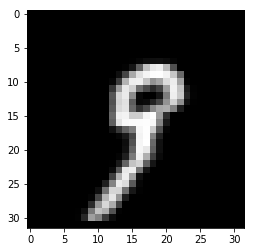

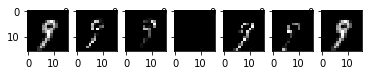

In [63]:
    datalabel = np.asarray(datalabel)
    datalabel = np.squeeze(datalabel)
    
    imageData = dataset[19]
#     print(imageData.shape)
    sideLength = imageData.shape[1]
    plt.imshow(np.reshape(imageData,[sideLength,sideLength]),cmap="gray")
    plt.figure()
#     checkOutPutsEachChannel(imageData,outputs,8)
    
    print(len(outputs))
#     for j in range(5):
    stagej = outputs[0].data.numpy()
    responsei = stagej[19,:,:,:]
    print(responsei.shape)
    n_columns = 7;
    n_rows = np.floor(responsei.shape[0]/(n_columns+1))+1 
    for i in range(responsei.shape[0]):
        plt.subplot(n_rows,n_columns,i+1)
        plt.imshow(responsei[i,:,:],cmap="gray")
        
        
        
    
    plt.show()